**1. INTRODUCTION**

This project aims to classify disaster related tweets using NLP techniques and RNN model. By analyzing the content of tweets, the model predicts whether a given tweet is about a real disaster or not. Thus facilitating quicker identification of critical information during emergencies.  

The training dataset consistes of 7613 rows and 5 columns :

**id**- a unique identifier for each tweet  
**text** - the text of the tweet  
**location** - the location the tweet was sent from (may be blank)  
**keyword** - a particular keyword from the tweet (may be blank)  
**target** - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)  

The test dataset has the same columns except the 'target', which has to be predicted by the model.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GRU, Bidirectional
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from wordcloud import WordCloud

In [4]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

**2. EDA** 

We will start the EDA process by first looking at the basic information about the dataset.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Next, we will check for any duplicates. 

In [8]:
train['text'].nunique()

7503

In [9]:
train[train.duplicated('text')].sort_values('text')

,id,keyword,location,text,target
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...,...,...,...
3461,4952,exploded,NaN,that exploded &amp; brought about the\nbeginni...,0
6103,8714,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve be...,1


We will remove the duplicate tweets from the dataset to ensure that the repeted tweets do not bias the model.

In [10]:
train_duplicates_removed = train.drop_duplicates(subset='text', keep='first')

In [11]:
train_duplicates_removed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7503 non-null   int64 
 1   keyword   7447 non-null   object
 2   location  5021 non-null   object
 3   text      7503 non-null   object
 4   target    7503 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 351.7+ KB


In [12]:
train_duplicates_removed.head().sort_values('text')

,id,keyword,location,text,target
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1


In [13]:
for i in range(5):
    print(train_duplicates_removed[train_duplicates_removed['target']==1]['text'].values[i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


In [14]:
for i in range(5):
    print(train_duplicates_removed[train_duplicates_removed['target']==0]['text'].values[i])

What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!


In [15]:
train_duplicates_removed.text.str.len().max()

157

Below is the target distribution generated to visualize the balance between disaster and non-disaster tweets. This helps to check for any class imbalance.

<Axes: xlabel='target', ylabel='count'>

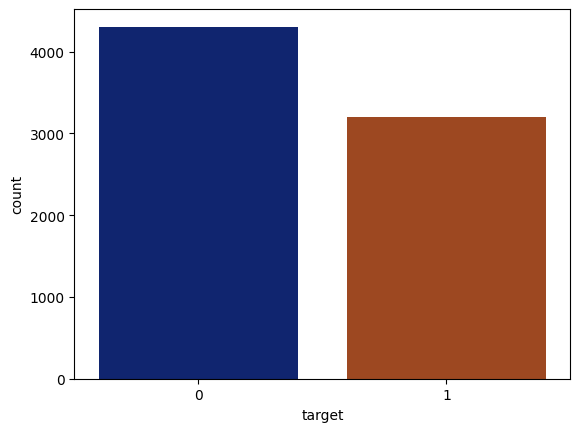

In [16]:
sns.countplot(x='target', data=train_duplicates_removed, palette='dark')

Next, we will create two seperate word clouds - one for disaster tweets and other for non-disaster tweets, to identify the most frequent words in each category, providing insights to the common themes and language patterns.

In [17]:
disaster_tweets = ' '.join([text for text in train_duplicates_removed[train_duplicates_removed['target']==1]['text']])
non_disaster_tweets = ' '.join([text for text in train_duplicates_removed[train_duplicates_removed['target']==0]['text']])

wordcloud_disaster = WordCloud(width=800, height=400, random_state=42).generate(disaster_tweets)
wordcloud_non_disaster = WordCloud(width=800, height=400, random_state=42).generate(non_disaster_tweets)


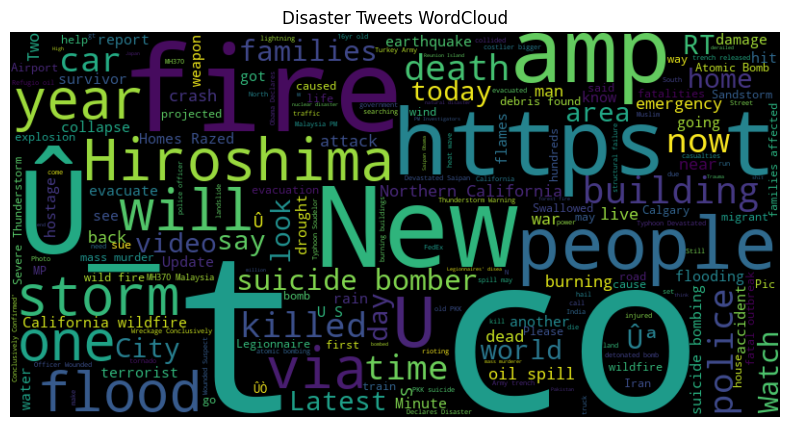

In [18]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Disaster Tweets WordCloud')
plt.axis('off')
plt.show()

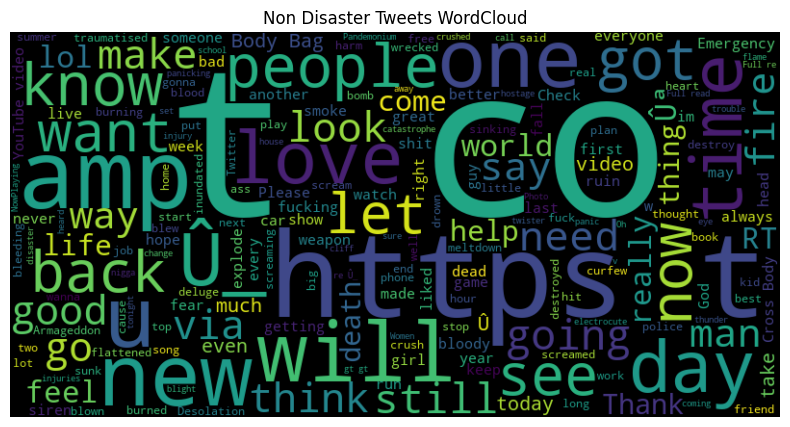

In [19]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Non Disaster Tweets WordCloud')
plt.axis('off')
plt.show()

To clean the dataset, URLs are removed from the tweet text as they do not contribute to the semantic understanding of the message.

In [20]:
url_pattern = r'http\S+|www\S+|https\S+'
tweets_with_urls = train_duplicates_removed[train_duplicates_removed['text'].str.contains(url_pattern,
                                                                                         regex=True)]
print(tweets_with_urls)

         id keyword                       location  \
31       48  ablaze                     Birmingham   
32       49  ablaze  Est. September 2012 - Bristol   
33       50  ablaze                         AFRICA   
35       53  ablaze                     London, UK   
37       55  ablaze                   World Wide!!   
...     ...     ...                            ...   
7603  10862     NaN                            NaN   
7604  10863     NaN                            NaN   
7606  10866     NaN                            NaN   
7608  10869     NaN                            NaN   
7612  10873     NaN                            NaN   

                                                   text  target  
31    @bbcmtd Wholesale Markets ablaze http://t.co/l...       1  
32    We always try to bring the heavy. #metal #RT h...       0  
33    #AFRICANBAZE: Breaking news:Nigeria flag set a...       1  
35    On plus side LOOK AT THE SKY LAST NIGHT IT WAS...       0  
37    INEC Office in 

In [21]:
def remove_urls(tweet):
    return re.sub(r'http\S+|www\S+|https\S+','',tweet, flags=re.MULTILINE)

train_duplicates_removed['text']=train_duplicates_removed['text'].apply(remove_urls)

print(train_duplicates_removed)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7604  10863     NaN      NaN   
7605  10864     NaN      NaN   
7606  10866     NaN      NaN   
7608  10869     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7604  #WorldNews Fallen powerlines on G:link tram: U...       1  
7605  on the flip side I'm at Walmart and there is a...       1  
7606  Suicide bomber 

/tmp/ipykernel_30/404834363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_duplicates_removed['text']=train_duplicates_removed['text'].apply(remove_urls)


Now, split the training data into training and validation sets and visualize the distribution on disaster and non disaster tweets in the split.

In [22]:
X = train_duplicates_removed['text']
y = train_duplicates_removed['target']

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y,
                                                  random_state=42)

In [24]:
train_df = pd.DataFrame({'text':X_train, 'target':y_train})

<Axes: xlabel='target', ylabel='count'>

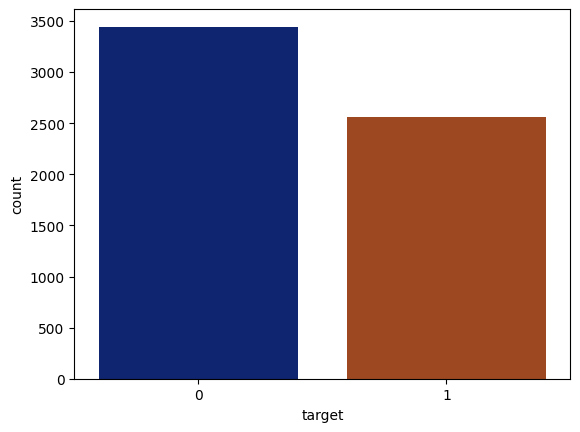

In [25]:
sns.countplot(x='target', data=train_df, palette='dark')

In [26]:
val_df = pd.DataFrame({'text':X_val, 'target':y_val})

<Axes: xlabel='target', ylabel='count'>

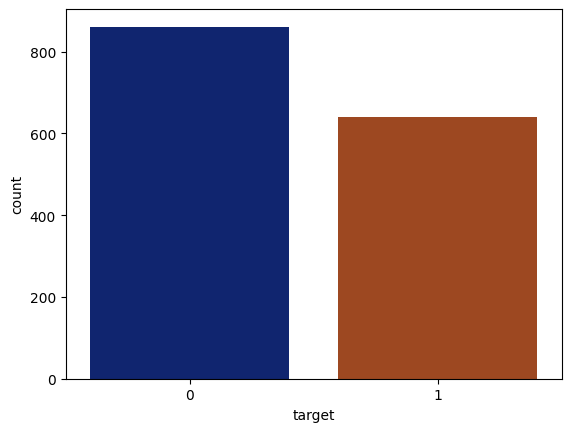

In [27]:
sns.countplot(x='target', data=val_df, palette='dark')

In [28]:
train_df.head().sort_values('text')

,text,target
225,70 years since we annihilated 100000 people in...,1
1526,@SyringeToAnger åÇ and probably even more. But...,0
5259,Refugio oil spill may have been costlier bigge...,1
1767,Traffic Collision - Ambulance Enroute: Elkhorn...,1
2538,Winter Desolation of Death is also on Tumblr: ...,0


**Tokenize & Pad Training Set**  

After splitting the dataset into training & validation set, the tweets are prepared for model input through tokenization, where each word is converted to a numerical token. Finally, the tokenized sequences are padded to ensure that all input sequences are of the same length, allowing them to be fed into the model in batches.

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])

train_sequences = tokenizer.texts_to_sequences(train_df['text'])
train_padded = pad_sequences(train_sequences,maxlen=200, padding='post')

train_label = np.array(train_df['target'])
    

**Tokenize & Pad Validation Set**

In [30]:
val_sequences = tokenizer.texts_to_sequences(val_df['text'])
val_padded = pad_sequences(val_sequences,maxlen=200, padding='post')

val_label = np.array(val_df['target'])

At the end of the EDA process, the data is cleaned, balanced and in correct format for training and model efficiency.

**3. Model**  

**Word Embedding**  

The model architecture for this project starts with a Keras Embedding layer, which transforms the input tokens into dense vectors that capture word relationships. This is a simple and efficient way to create word embeddings directly within a neural network model. It maps words (or tokens) into dense vectors of fixed size, where similar words are closer in the vector space. This layer learns the embedding weights during the training process. Unlike pre trained embeddings (like GloVe or Word2Vec), the Keras Embedding layer learns embeddings specific to the task and dataset, which can improve performance for some problems. This layer is crucial for learning word representations specific to disaster and non-disaster tweets.


**GRU Layer**  

After the embedding layer, a GRU layer is added to capture sequential dependencies in the tweet text. In other words, this layer helps the model understand context and temporal information in the tweet sequence.  

**Dense Layer**

Dense layer with ReLU activation is added to further refine the learned features.  

**Output Layer**

For binary classifications, a sigmoid activation is used to produce a probability between 0 and 1, which can be the threshold to classify the tweet.  

**Compiling**  

The model is compiled using adam optimizer and binary_crossentropy loss functions is used.

In [31]:
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

15837


In [32]:
model = tf.keras.Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=200))
model.add(GRU(units=128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None,200))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 200)       │     3,167,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │       126,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,310,761 (12.63 MB)

 Trainable params: 3,310,761 (12.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 51s 255ms/step - accuracy: 0.5706 - loss: 0.6848 - val_accuracy: 0.5736 - val_loss: 0.6823
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 248ms/step - accuracy: 0.5688 - loss: 0.6856 - val_accuracy: 0.5736 - val_loss: 0.6824
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 252ms/step - accuracy: 0.5681 - loss: 0.6845 - val_accuracy: 0.5736 - val_loss: 0.6823
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 248ms/step - accuracy: 0.5746 - loss: 0.6824 - val_accuracy: 0.5736 - val_loss: 0.6828
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 250ms/step - accuracy: 0.5731 - loss: 0.6835 - val_accuracy: 0.5736 - val_loss: 0.6823
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 246ms/step - accuracy: 0.5738 - loss: 0.6834 - val_accuracy: 0.5736 - val_loss: 0.6824
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 48s 255ms/step - accuracy: 0.5772 - loss: 0.6819 - val_accuracy: 0.5736 - val_loss: 0.6823
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 48s 257ms/step - accuracy: 0.5809 - loss: 0

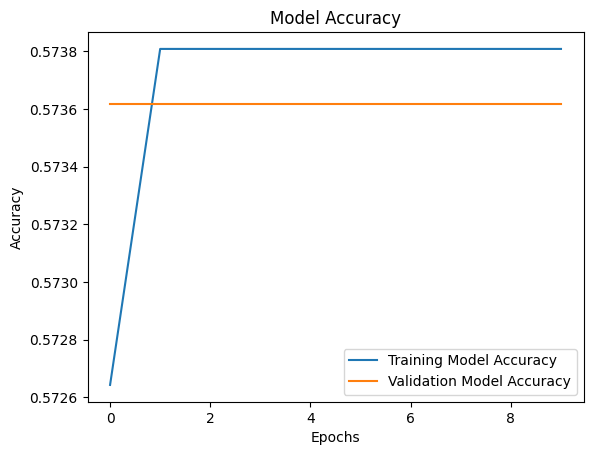

In [33]:
model_trained = model.fit(train_padded,train_label,epochs=10,batch_size=32
                    ,validation_data=(val_padded, val_label))

plt.plot(model_trained.history['accuracy'], label = 'Training Model Accuracy')
plt.plot(model_trained.history['val_accuracy'], label = 'Validation Model Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


The constant accuracy after each epoch indicates that there isn't much learning happening. Let us do some hyperparameter tuning to enhance the model.

**4. Results & Analysis**

**Hyperparameter Tuning**   

* Adjust the learning rate to see if that enhances model accuracy. Learning rate controls how quickly or slowly the model updates the weights during training.  

* Create a new model with the same architecture as the old model, but with a dropout value of 0.3 instead of 0.2

* Add in a bidirectional GRU. A Bidirectional GRU, or BiGRU, is a sequence processing model that consists of two GRUs. one taking the input in a forward direction, and the other in a backwards direction. It is a bidirectional recurrent neural network with only the input and forget gates

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 80s 395ms/step - accuracy: 0.7105 - loss: 0.5822 - val_accuracy: 0.7522 - val_loss: 0.5230
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 388ms/step - accuracy: 0.8973 - loss: 0.2592 - val_accuracy: 0.7895 - val_loss: 0.5139
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 72s 385ms/step - accuracy: 0.9635 - loss: 0.1071 - val_accuracy: 0.7715 - val_loss: 0.7447
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 387ms/step - accuracy: 0.9791 - loss: 0.0521 - val_accuracy: 0.7841 - val_loss: 0.8335
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 74s 392ms/step - accuracy: 0.9871 - loss: 0.0313 - val_accuracy: 0.7801 - val_loss: 1.4181
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 386ms/step - accuracy: 0.9873 - loss: 0.0282 - val_accuracy: 0.7788 - val_loss: 1.2344
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 384ms/step - accuracy: 0.9911 - loss: 0.0211 - val_accuracy: 0.7548 - val_loss: 1.3016
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 74s 393ms/step - accuracy: 0.9903 - loss: 0

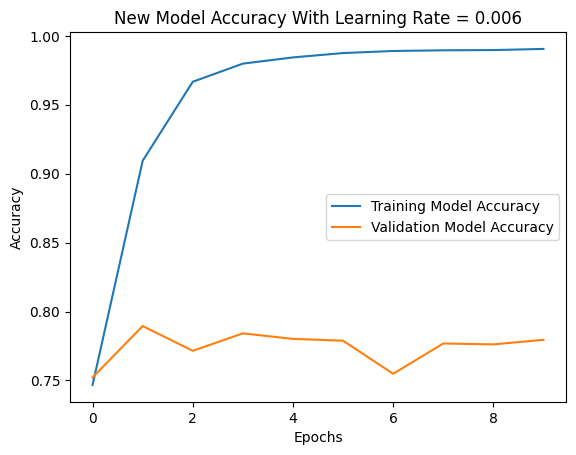

In [39]:
Newmodel = tf.keras.Sequential()
new_learning_rate = 0.006

Newmodel.add(Embedding(input_dim=vocab_size, output_dim=200))
Newmodel.add(Bidirectional(GRU(units=128, return_sequences=False)))
Newmodel.add(Dropout(0.2))
Newmodel.add(Dense(units=128, activation='relu'))
Newmodel.add(Dense(1,activation='sigmoid'))

Newmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=new_learning_rate),
             loss='binary_crossentropy', metrics=['accuracy'])

Newmodel_trained = Newmodel.fit(train_padded,train_label,epochs=10,batch_size=32,
                    validation_data=(val_padded, val_label))

plt.plot(Newmodel_trained.history['accuracy'], label = 'Training Model Accuracy')
plt.plot(Newmodel_trained.history['val_accuracy'], label = 'Validation Model Accuracy')
plt.title('New Model Accuracy With Learning Rate = 0.006')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Learning Rate** : Adjusting the learning rate to 0.06 helped the model find a better balance between speed and convergence stability  

**Dropout Rate** : Increasing the dropout rate to 0.3 reduced overfitting, making the model more generalizable.  

**Model Architecture** : Introducing a BiGRU improved the model's ability to capture sequential dependencies from both directions, leading to better feature extraction.

**5. Test & Submission**

In [40]:
X_test = test['text'].values
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences,maxlen=200, padding='post')

In [41]:
predictions = Newmodel.predict(test_padded)
predicted_labels = (predictions>0.5).astype(int)

102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step


In [42]:
output_df = pd.DataFrame({'id':test['id'],'target':predicted_labels.flatten()})
output_df.to_csv('submission.csv',index=False)

6. Conclusion  

Key learnings from this project include the necessity of experimenting with different hyperparameters and model configurations to achieve optimal results.

**Future Work** : Moving forward, further improvements could be made by exploring advanced techniques such as using pre-trained embeddings like GloVe or FastText, which may provide richer word representations. 